<a href="https://colab.research.google.com/github/Stanley487/Data-Science/blob/main/End_to_End_Machine_Learning_Pipeline_for_Waste_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Problem Statement**
**Business Problem:**
In the waste management industry of Ghana, accurately sorting waste into different categories such as recyclable and organic is crucial for effective recycling processes. Misclassification of waste can lead to increased operational costs, reduced recycling efficiency, and environmental harm. I seek to develop an automated waste classification system using machine learning to improve waste sorting accuracy and efficiency.

**Importance:**
Solving this problem will significantly enhance the Countries waste sorting process by reducing human error, lowering operational costs, and increasing the amount of waste that can be recycled. Accurate waste classification also contributes to better environmental practices and regulatory compliance.

**Data Collection:**
The relevant data for this task includes images of waste categorized into recyclable and organic waste. These images will be collected using waste bins equipped with cameras or from publicly available datasets.

**Machine Learning Formulation:**
The problem can be formulated as a supervised learning task where the goal is to classify images of waste into one of two categories: recyclable or organic. This is a binary image classification problem.

# 2. Data Exploration
**Dataset Overview:**
The dataset contains images of waste that belong to two categories: recyclable and organic. The images are loaded from directories containing labeled subfolders corresponding to each category.

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import os
from zipfile import ZipFile

In [10]:

# Specify the zip file path
zip_file_path = '/content/waste-collection (2).zip'

# Unzip the file
with ZipFile(zip_file_path, 'r') as zip_ref:
   zip_ref.extractall('/content/waste-collection')

print("Unzipping completed!")

# Verify files
extracted_path = '/content/waste-collection'
print("Files in the extracted directory:")
print(os.listdir(extracted_path))

Unzipping completed!
Files in the extracted directory:
['waste-collection']


In [11]:
train_path = "/content/waste-collection/waste-collection/DATASET/TRAIN/"
test_path = "/content/waste-collection/waste-collection/DATASET/TEST/"

from glob import glob

# Load and label images
x_data = []
y_data = []

for category in glob(train_path+'/*'):
    for file in glob(category+'/*'):
        img_array = cv2.imread(file)
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        x_data.append(img_array)
        y_data.append(category.split("/")[-1])

data = pd.DataFrame({'image': x_data, 'label': y_data})

data.shape

(22564, 2)

# **Data Quality Issues:**

**Class Imbalance:** The dataset may suffer from class imbalance if one category has significantly more images than the other.
Image Quality: Variations in image resolution, lighting, and background noise could affect model performance.
Evaluation Metrics:

**Accuracy:** Suitable if the classes are balanced.
Precision, Recall, F1-Score: Recommended if class imbalance is present to better assess model performance.

# 3. Data Preprocessing and Feature Engineering
**Data Preprocessing Steps:**

**Rescaling:** bold text Normalize pixel values to the range [0, 1].

**Resizing:** Resize all images to a standard size, e.g., 224x224 pixels, for uniform input to the model.

**Augmentation:** Apply transformations like rotation, flipping, and zoom to increase the diversity of training data.

In [12]:
# !pip install tensorflow
import tensorflow as tf

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

A pie chart to visualize the distribution of two waste categories—"Organic" and "Recyclable"—in the dataset

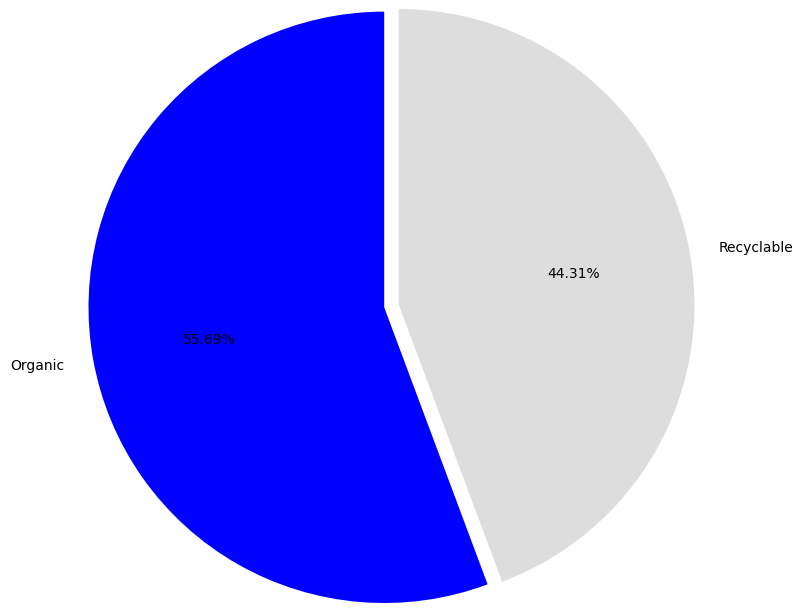

In [13]:
colors = ['blue','#ddd']
plt.pie(data.label.value_counts(),startangle=90,explode=[0.05,0.05],autopct='%0.2f%%',
        labels=['Organic', 'Recyclable'], colors= colors,radius=2)
plt.show()

# 4. Model Training
**Model Architecture:**

**Convolutional Neural Network (CNN):** A CNN is chosen for its effectiveness in image classification tasks. The model consist of several convolutional layers followed by max-pooling, dropout for regularization, and dense layers for classification.
python

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense

model = Sequential([
    Conv2D(32, (3, 3), input_shape=(224, 224, 3)),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3)),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3)),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(256),
    Activation('relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])



/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# Model Training:

The model is trained using the augmented dataset with appropriate batch size and number of epochs.

In [15]:
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

model.fit(
    train_generator,
    epochs=1,
    validation_data=test_generator
)


Found 22564 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


706/706 ━━━━━━━━━━━━━━━━━━━━ 3351s 5s/step - accuracy: 0.7650 - loss: 0.5999 - val_accuracy: 0.8456 - val_loss: 0.3631


In [16]:
# Save the model to a file
model.save('waste_classification_model.h5')


# 5. Model Assessment
**Performance Evaluation:**

Evaluating the trained model on an unseen test set to estimate its generalization performance.

Confusion Matrix: Analyze misclassifications.
Precision, Recall, F1-Score: Provide a balanced view of model performance.

In [17]:
# Prediction function
def predict_func(img):
    plt.figure(figsize=(6,4))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.tight_layout()
    img = cv2.resize(img, (224, 224))
    img = np.reshape(img, [-1, 224, 224, 3])
    result = np.argmax(model.predict(img))
    if result == 0:
        print("\033[94m"+"This image -> Recyclable"+"\033[0m")
    elif result == 1:
        print("\033[94m"+"This image -> Organic"+"\033[0m")

In [18]:
# Evaluate and display accuracy
test_loss, test_acc = model.evaluate(test_generator)
print("Test Accuracy:", test_acc)

79/79 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.8447 - loss: 0.3588
Test Accuracy: 0.8456028699874878


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step
This image -> Organic
79/79 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step
              precision    recall  f1-score   support

           0       0.55      0.67      0.60      1401
           1       0.43      0.31      0.36      1112

    accuracy                           0.51      2513
   macro avg       0.49      0.49      0.48      2513
weighted avg       0.50      0.51      0.50      2513



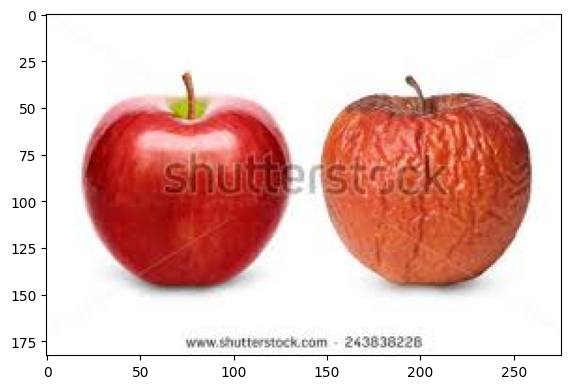

In [20]:
# Example Predictions
sample_image = cv2.imread("/content/organic_000244_photo.jpg")
predict_func(sample_image)

# Classification report
from sklearn.metrics import classification_report
predictions = model.predict(test_generator)
print(classification_report(test_generator.classes, predictions.argmax(axis=1)))

In [21]:
!pip install opencv-python-headless tensorflow


<IPython.core.display.Javascript object>

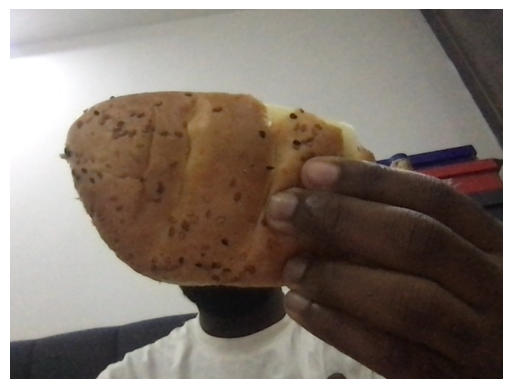

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
Predicted Class: Recyclable, Confidence: 0.80


In [23]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from PIL import Image
import io
import base64
from google.colab import output
from IPython.display import display, Javascript
import cv2
from matplotlib import pyplot as plt

# Load the trained model
model = load_model('waste_classification_model.h5')


class_labels = ['Recyclable', 'Organic']

# JavaScript to capture an image using the webcam
def take_photo():
    js = Javascript('''
    async function takePhoto() {
        const div = document.createElement('div');
        const video = document.createElement('video');
        const button = document.createElement('button');
        const canvas = document.createElement('canvas');
        const context = canvas.getContext('2d');
        const stream = await navigator.mediaDevices.getUserMedia({video: true});

        document.body.appendChild(div);
        div.appendChild(video);
        div.appendChild(button);
        video.srcObject = stream;
        await video.play();

        // Create button to take photo
        button.textContent = 'Capture';
        await new Promise((resolve) => button.onclick = resolve);

        // Capture image from video
        canvas.width = video.videoWidth;
        canvas.height = video.videoHeight;
        context.drawImage(video, 0, 0, canvas.width, canvas.height);
        const dataUrl = canvas.toDataURL('image/jpeg');

        stream.getTracks().forEach(track => track.stop());
        div.remove();
        return dataUrl;
    }
    takePhoto();
    ''')
    display(js)
    data = output.eval_js('takePhoto()')
    return data


photo_data = take_photo()

# Convert the base64 image data to a numpy array
def decode_image(data):
    image_bytes = base64.b64decode(data.split(',')[1])
    img = Image.open(io.BytesIO(image_bytes))
    return img

# Process the captured image
captured_image = decode_image(photo_data)
plt.imshow(captured_image)
plt.axis('off')
plt.show()

# Preprocess the image for the model
captured_image = captured_image.resize((224, 224))
image_array = np.array(captured_image) / 255.0
image_array = np.expand_dims(image_array, axis=0)

# Make predictions
predictions = model.predict(image_array)
predicted_class = class_labels[np.argmax(predictions)]
confidence = np.max(predictions)

# Display the result
print(f"Predicted Class: {predicted_class}, Confidence: {confidence:.2f}")


# 6. Final Discussion
**Strengths and Limitations:**

**Strengths:** The CNN model is effective for image classification tasks and benefits from the augmentation techniques used during training.
**Limitations:** The model may not generalize well to images with different lighting conditions or backgrounds not represented in the training data.
Business Implications:

The developed model can be integrated into waste management systems to automate the sorting process, reducing costs and increasing efficiency.
Data-Driven Recommendations:

Invest in gathering more diverse image data, particularly from underrepresented categories, to improve model robustness.
Consider implementing a multi-class classification model if additional waste categories are added in the future.
Model Explainability:

Analyze the most informative features and understand which patterns the model relies on for classification using techniques like Grad-CAM.